# 09-B. MNISTを用いた文字認識（CNN）


---
## 目的
畳み込みニューラルネットワーク（CNN）を用いてMNISTデータセットに対する文字認識を行う．
評価はConfusion Matrixにより各クラスの認識率を用いて行う．

GPUを用いたネットワークの計算を行う．

## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではChainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

## モジュールのインポート
はじめに必要なモジュールをインポートする．

In [ ]:
from time import time
import numpy as np
import chainer
from chainer import cuda, optimizers
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算をChainerで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．


In [2]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


## データセットの読み込みと確認
学習データ（MNIST Dataset）を読み込みます．

In [3]:
train_dataset, test_dataset = chainer.datasets.get_mnist()
train_x,train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


### MNISTデータセットの表示

MNISTデータセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

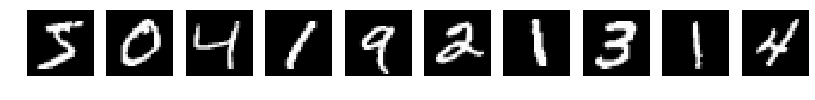

In [4]:
import matplotlib.pyplot as plt

cols = 10

plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(cols):
    ax = fig.add_subplot(1, cols, c + 1)
    ax.imshow(train_x[c].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()
plt.show()

## ネットワークモデルの定義

畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．

１層目の畳み込み層は入力チャンネル数が１，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．２層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．
１つ目の全結合層は入力ユニット数は不定とし，出力は1024としています．次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．これらの各層の構成を\__init\__関数で定義します．

次に，\__call\__関数では，定義した層を接続して処理するように記述します．\__call\__関数の引数xは入力データです．それを\__init\__関数で定義したconv1に与え，その出力を活性化関数であるrelu関数に与えます．そして，その出力をmax_pooling_2dに与えて，プーリング処理結果をhとして出力します．hはconv2に与えられて畳み込み処理とプーリング処理を行います．そして，出力hをl1に与えて全結合層の処理を行います．
最終的にl3の全結合層の処理を行った出力hを戻り値としています．


In [ ]:
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(1, 16, 3) 
            self.conv2 = L.Convolution2D(16, 32, 3) 
            self.l1 = L.Linear(None, 1024)
            self.l2 = L.Linear(1024, 1024)
            self.l3 = L.Linear(1024, 10)

    def __call__(self, x):
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．
ここでは，GPUで学習を行うために，modelをGPUに送るto_gpu関数を利用しています．


学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．また，学習率を0.01，モーメンタムを0.9として引数に与えます．そして，最適化方法のsetup関数にネットワークモデルを与えます．

In [9]:
model = CNN()
model.to_gpu()

optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

## データの変換

Chainerを用いた場合，畳み込み層への入力するデータは[ミニバッチサイズ，チャンネル，画像の縦幅，画像の横幅]という配列の形状である必要があります．
そのため，reshape関数を用いて，配列の形状を変換します．
その後，transpose関数を用いて，配列の次元の順番を入れ替えることで，ネットワークへ入力するデータの形式に変更します．

ここでは，GPUに対応した行列演算モジュールのcupyを呼び出しており，学習およびテストデータをcupyの形式に変換します．
cupyはnumpyと互換性があります．

In [10]:
# 配列の形状変換
train_x = train_x.reshape(60000, 28, 28, 1).transpose(0,3,1,2)
test_x = test_x.reshape(10000, 28, 28, 1).transpose(0,3,1,2)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

# cupyへの変換
xp = cuda.cupy
train_x = xp.array(train_x, dtype=xp.float32)
train_y = xp.array(train_y, dtype = xp.int32)
test_x = xp.array(test_x, dtype=xp.float32)
test_y = xp.array(test_y, dtype = xp.int32)

(60000, 1, 28, 28) (60000,)
(10000, 1, 28, 28) (10000,)


## 学習
１回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を10とします．MNISTの学習データサイズを取得し，１エポック内における更新回数を求めます．学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．各更新において，学習用データと教師データをそれぞれxとtとし，to_gpu関数でGPUに転送します．学習モデルにxを与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベルtとの誤差をsoftmax coross entropy誤差関数で算出します．また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．


In [11]:
batch_size = 100
epoch_num = 10
train_data_num = train_x.shape[0]

for epoch in range(epoch_num):
    sum_loss = 0
    sum_accuracy = 0
    perm = xp.random.permutation(train_data_num)
    for i in range(0, train_data_num, batch_size):
        x = Variable(cuda.to_gpu(train_x[perm[i:i+batch_size]]))
        t = Variable(cuda.to_gpu(train_y[perm[i:i+batch_size]]))

        y = model(x)        
        model.zerograds()
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        loss.backward()
        optimizer.update()
        sum_loss += loss.data*batch_size
        sum_accuracy += acc.data*batch_size

    print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss/train_data_num, sum_accuracy/train_data_num))

epoch: 1, mean loss: 0.21716072, mean accuracy: 0.93256664
epoch: 2, mean loss: 0.06118925, mean accuracy: 0.98135
epoch: 3, mean loss: 0.042200293, mean accuracy: 0.98658335
epoch: 4, mean loss: 0.032672938, mean accuracy: 0.9892333
epoch: 5, mean loss: 0.02529291, mean accuracy: 0.9917833
epoch: 6, mean loss: 0.0193544, mean accuracy: 0.9939
epoch: 7, mean loss: 0.014604744, mean accuracy: 0.9956833
epoch: 8, mean loss: 0.0116014555, mean accuracy: 0.9964167
epoch: 9, mean loss: 0.0094543435, mean accuracy: 0.9971
epoch: 10, mean loss: 0.008864799, mean accuracy: 0.99705


## テスト
学習したネットワークを用いて，テストデータに対する認識率の確認を行います．

In [12]:
cnt = 0
test_data_num = test_x.shape[0]

for i in range(test_data_num):
    x = Variable(cuda.to_gpu(test_x[i].reshape(1,1,28,28)))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1

print("test accuracy: {}".format(cnt/test_data_num))

test accuracy: 0.9906


## 課題

1. ネットワーク構造を変えて実験しましょう． 
    * まず，1層目の畳み込み層のフィルタ数を32にしましょう．また，2層目の畳み込み層のフィルタ数を64にしましょう．
    * 次に，中間層のユニット数を2048にしましょう．

2. 最適化の方法をAdamに変えて実験しましょう．

3. エポック数やミニバッチサイズを変えて実験しましょう．
    * まず，ミニバッチサイズを128にしましょう．
    * 次に，エポック数を50にしましょう．


## 別のコードの書き方
前回の多層パーセプトロンと同様にTrainerを利用したプログラムを作成します．

In [ ]:
import numpy as np
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

batch_size = 100
epoch_num = 10

n_units = 50
out_units = 10

model = L.Classifier(CNN())
model.to_gpu() 
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)  
  
train_dataset, test_dataset = chainer.datasets.get_mnist(ndim =3)

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size,    repeat=False, shuffle=False)

updater = training.updaters.StandardUpdater( train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')

trainer.extend(extensions.Evaluator(test_iter, model, device=0))

trainer.extend(extensions.dump_graph('main/loss'))

trainer.extend(extensions.LogReport())

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],  'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.282162    0.0656008             0.912784       0.9784                    6.24631       
2           0.0632516   0.0500385             0.980782       0.9833                    12.8076       
3           0.0424177   0.0356537             0.986649       0.9877                    19.4272       
4           0.0317902   0.032511              0.990032       0.9889                    26.0255       
5           0.0254789   0.0338489             0.992032       0.9904                    33.0992       
6           0.0194992   0.0292007             0.994065       0.9897                    39.9385       
7           0.0151577   0.0337436             0.995265       0.99                      46.5978       
8           0.0118071   0.0285756             0.996533       0.9912                    53.384        
9           0.00990797  0.0299046             0.996916       0.9906                 